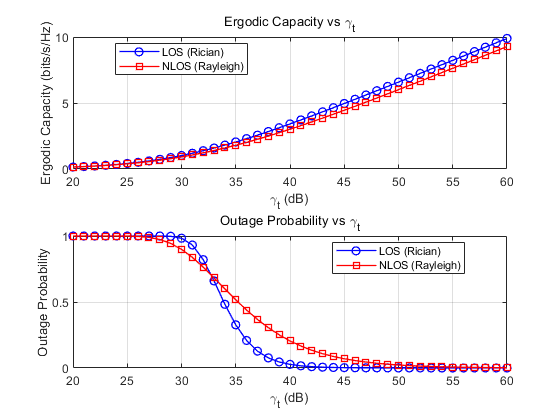

In [1]:
clear; clc; close all;

%% Given Parameters
ht = 10;    % height of transmitter (m)
hu = 6;     % height of receiver (m)
dx = 80;    % horizontal distance between transmitter and receiver (m)
Gt_dBi = 20; % Transmit antenna gain in dBi
Gr_dBi = 20; % Receive antenna gain in dBi
f = 900e6;  % frequency (Hz)
gamma_th_dB = 4; % SNR outage threshold in dB
K_dB = 8;   % Rician K-factor in dB for LOS scenario

% Convert to linear scale
Gt = 10^(Gt_dBi/10);
Gr = 10^(Gr_dBi/10);
gamma_th = 10^(gamma_th_dB/10); 
K = 10^(K_dB/10);  % Rician K-factor linear scale

c = 3e8;            % speed of light (m/s)
lambda = c/f;       % wavelength (m)

%% Distance and Path-Loss Calculation
r = sqrt(dx^2 + (ht - hu)^2); % direct distance between Tx and Rx
PL_r = Gt * Gr * (lambda/(4*pi*r))^2; % free space path-loss

%% Simulation Parameters
N = 1e6;             % number of Monte-Carlo realizations
gamma_t_dB_vec = 20:60; % range of transmit SNR in dB
gamma_t_lin_vec = 10.^(gamma_t_dB_vec/10);

% Pre-allocate results
ergodic_capacity_LOS = zeros(length(gamma_t_lin_vec),1);
outage_prob_LOS = zeros(length(gamma_t_lin_vec),1);

ergodic_capacity_NLOS = zeros(length(gamma_t_lin_vec),1);
outage_prob_NLOS = zeros(length(gamma_t_lin_vec),1);

%% Generate channels
% For Rayleigh (NLOS): h ~ CN(0,1), so |h|^2 ~ Exp(1)
% For Rician (LOS): amplitude |h| follows Rician distribution
% h = sqrt(K/(K+1))*s + sqrt(1/(K+1))*g, where s ~ deterministic phasor, g ~ CN(0,1)
% The amplitude distribution can be generated by using: 
% |h| = sqrt( (sqrt(K/(K+1)))^2 + 2*(sqrt(K/(K+1)))*Re(...) + ... )
% but directly we can use a Rician distribution. 
% Alternatively, we can construct h explicitly:
% h_LOS = (sqrt(K/(K+1)) + sqrt(1/(K+1)/2)*(randn(N,1)+1j*randn(N,1)));
% Actually, to generate Rician fading with factor K:
% h_LOS = sqrt(K/(K+1)) + sqrt(1/(2*(K+1)))*(randn(N,1)+1j*randn(N,1));
% This h_LOS will have mean not zero. The variance of the scattered part is 1/(K+1).

% LOS scenario: Rician fading
% deterministic component (LoS)
h_LOS = sqrt(K/(K+1)) + sqrt(1/(2*(K+1)))*(randn(N,1)+1j*randn(N,1));
% NLOS scenario: Rayleigh fading
h_NLOS = (randn(N,1)+1j*randn(N,1))/sqrt(2); % CN(0,1)

% Compute |h|^2
h_LOS_mag_sq = abs(h_LOS).^2;
h_NLOS_mag_sq = abs(h_NLOS).^2;

%% Monte-Carlo for each gamma_t
for idx = 1:length(gamma_t_lin_vec)
    gamma_t_lin = gamma_t_lin_vec(idx);
    
    % SNR = gamma_t * PL(r) * |h|^2
    SNR_LOS = gamma_t_lin * PL_r * h_LOS_mag_sq;
    SNR_NLOS = gamma_t_lin * PL_r * h_NLOS_mag_sq;
    
    % Ergodic capacity = E[log2(1+SNR)]
    ergodic_capacity_LOS(idx) = mean(log2(1 + SNR_LOS));
    ergodic_capacity_NLOS(idx) = mean(log2(1 + SNR_NLOS));
    
    % Outage probability = P(SNR <= gamma_th)
    outage_prob_LOS(idx) = mean(SNR_LOS <= gamma_th);
    outage_prob_NLOS(idx) = mean(SNR_NLOS <= gamma_th);
end

%% Plot Results

figure;
subplot(2,1,1);
plot(gamma_t_dB_vec, ergodic_capacity_LOS, 'b-o', 'LineWidth',1); hold on;
plot(gamma_t_dB_vec, ergodic_capacity_NLOS, 'r-s', 'LineWidth',1);
grid on; xlabel('\gamma_t (dB)'); ylabel('Ergodic Capacity (bits/s/Hz)');
title('Ergodic Capacity vs \gamma_t');
legend('LOS (Rician)','NLOS (Rayleigh)','Location','Best');

subplot(2,1,2);
plot(gamma_t_dB_vec, outage_prob_LOS, 'b-o', 'LineWidth',1); hold on;
plot(gamma_t_dB_vec, outage_prob_NLOS, 'r-s', 'LineWidth',1);
grid on; xlabel('\gamma_t (dB)'); ylabel('Outage Probability');
title('Outage Probability vs \gamma_t');
legend('LOS (Rician)','NLOS (Rayleigh)','Location','Best');


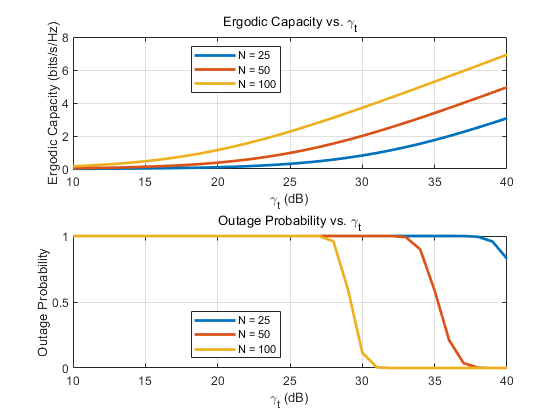

In [2]:
clear; clc; close all;

%% Given Parameters
N_values = [25, 50, 100];  % Number of IRS elements
Gt_dBi = 10; Gr_dBi = 10;
Gt = 10^(Gt_dBi/10);  Gr = 10^(Gr_dBi/10);

L = 2; W = 2;      % IRS dimensions (m)
dh = 25; dg = 25;  % distances (m)
phi_deg = 30;      % angle in degrees
phi = deg2rad(phi_deg);

f = 900e6;  % frequency (optional, not explicitly needed if we trust given formula)
c = 3e8;    % speed of light

gamma_th_dB = 10; 
gamma_th = 10^(gamma_th_dB/10); % Outage threshold in linear scale

% Transmit SNR (gamma_t) range
gamma_t_dB_vec = 10:40;
gamma_t_lin_vec = 10.^(gamma_t_dB_vec/10);

% Path-loss as given:
% PL = (Gt Gr (L W / (4 π² dh dg))² cos²(φ))
PL = Gt * Gr * ((L*W)/(4*pi^2*dh*dg))^2 * cos(phi)^2;

% Number of realizations
Nreal = 1e6;

%% Pre-allocate Results
% We'll store results for each N scenario
ergodic_capacity = zeros(length(N_values), length(gamma_t_lin_vec));
outage_prob = zeros(length(N_values), length(gamma_t_lin_vec));

%% Monte Carlo Simulation for each N
for n_idx = 1:length(N_values)
    N_irs = N_values(n_idx);

    % Generate channels
    % h_i ~ CN(0,1), g_i ~ CN(0,1)
    % Generate N x Nreal or Nreal x N?
    % For memory efficiency, generate as [N_irs, Nreal] and sum over dimension.
    h = (randn(N_irs, Nreal) + 1j*randn(N_irs, Nreal))/sqrt(2);
    g = (randn(N_irs, Nreal) + 1j*randn(N_irs, Nreal))/sqrt(2);

    % With optimal phase shifts, SNR = gamma_t * PL * (sum |h_i| |g_i|)^2
    % First compute |h_i| and |g_i|
    abs_h = abs(h);
    abs_g = abs(g);

    % sum of products |h_i||g_i|
    sum_abs_hg = sum(abs_h.*abs_g,1); % 1xNreal

    for gt_idx = 1:length(gamma_t_lin_vec)
        gamma_t_lin = gamma_t_lin_vec(gt_idx);

        % Compute SNR samples
        SNR_samples = gamma_t_lin * PL * (sum_abs_hg.^2); % 1 x Nreal

        % Ergodic capacity = E[log2(1+SNR)]
        ergodic_capacity(n_idx, gt_idx) = mean(log2(1+SNR_samples));

        % Outage probability = P(SNR <= gamma_th)
        outage_prob(n_idx, gt_idx) = mean(SNR_samples <= gamma_th);
    end

    % Clear large variables from memory if desired
    clear h g abs_h abs_g sum_abs_hg
end

%% Plot results
figure;
for n_idx = 1:length(N_values)
    subplot(2,1,1);
    plot(gamma_t_dB_vec, ergodic_capacity(n_idx,:), 'LineWidth',2); hold on; grid on;
    xlabel('\gamma_t (dB)');
    ylabel('Ergodic Capacity (bits/s/Hz)');
    title('Ergodic Capacity vs. \gamma_t');
    legendStrings{n_idx} = sprintf('N = %d', N_values(n_idx));

    subplot(2,1,2);
    plot(gamma_t_dB_vec, outage_prob(n_idx,:), 'LineWidth',2); hold on; grid on;
    xlabel('\gamma_t (dB)');
    ylabel('Outage Probability');
    title('Outage Probability vs. \gamma_t');
end

subplot(2,1,1);
legend(legendStrings, 'Location', 'Best');

subplot(2,1,2);
legend(legendStrings, 'Location', 'Best');
